In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#test_data = pd.read_csv("test_set.tsv",sep='\t', encoding='ISO-8859-1')
df = pd.read_csv("training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1',
                            usecols = ['essay_id', 'essay_set', 'essay','domain1_score']).dropna(axis=1)
#valid_data = pd.read_csv("valid_set.tsv",sep='\t', encoding='ISO-8859-1')

In [10]:
df

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40


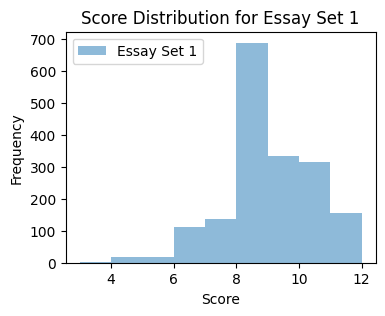

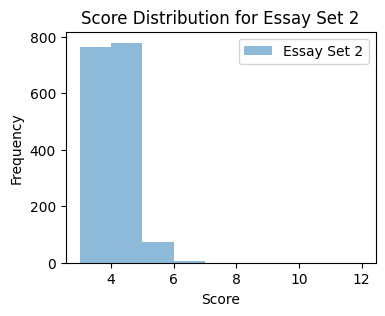

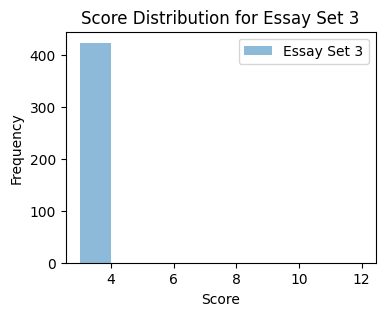

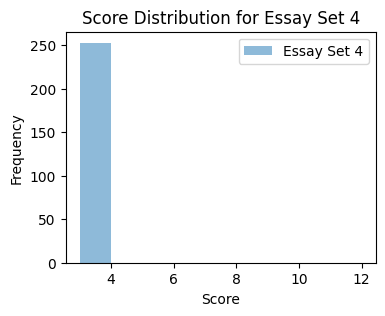

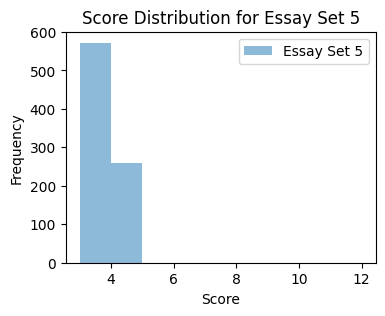

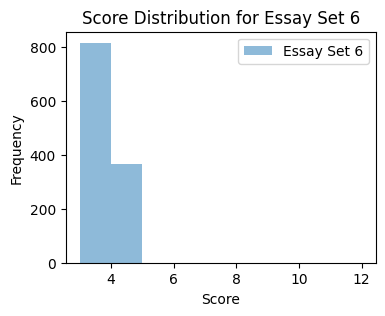

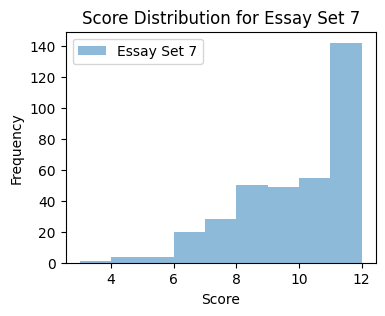

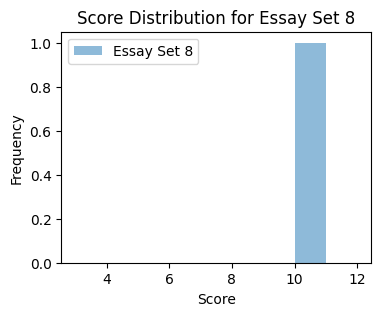

In [24]:
# Group the data by essay_set
grouped_df = df.groupby('essay_set')

# Loop through each essay_set and create a histogram of the domain1_score
for essay_set, group in grouped_df:
    plt.figure(figsize=(4, 3))
    plt.hist(group['domain1_score'], bins=range(3,13), alpha=0.5, label=f'Essay Set {essay_set}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(f'Score Distribution for Essay Set {essay_set}')
    plt.legend()
    plt.show()

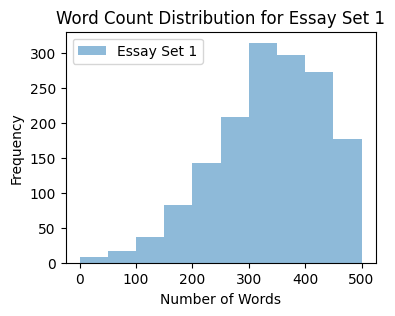

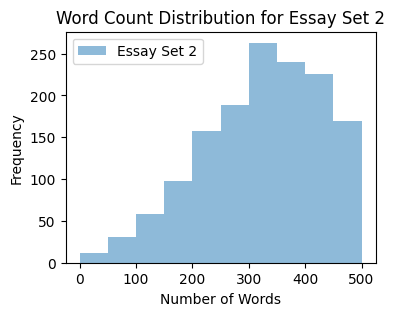

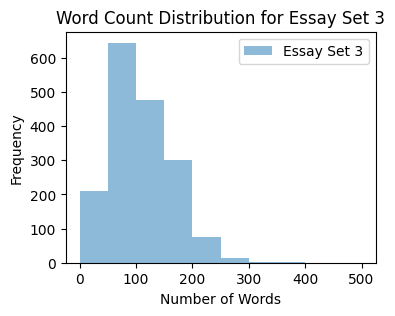

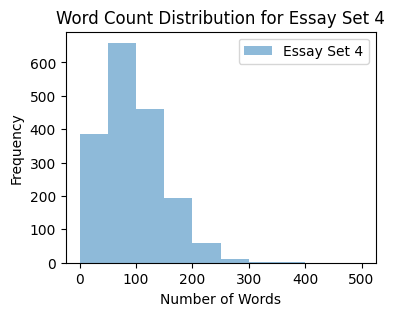

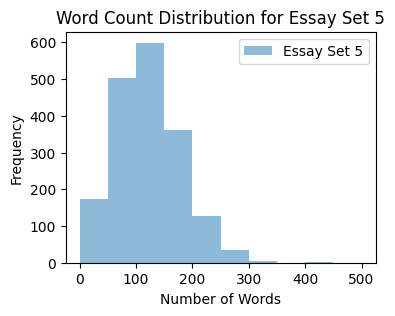

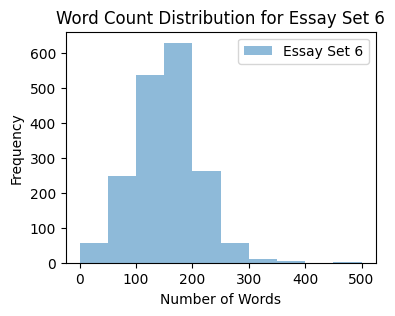

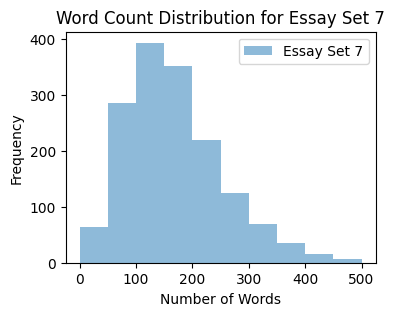

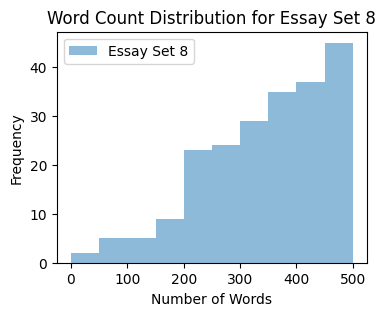

In [26]:
# Group the data by essay_set
grouped_df = df.groupby('essay_set')

# Loop through each essay_set and create a histogram of the number of words per essay
for essay_set, group in grouped_df:
    # Calculate the number of words in each essay and plot a histogram
    word_counts = group['essay'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(4, 3))
    plt.hist(word_counts, bins=range(0, 550, 50), alpha=0.5, label=f'Essay Set {essay_set}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title(f'Word Count Distribution for Essay Set {essay_set}')
    plt.legend()
    plt.show()

In [17]:
len(df)

12976

In [23]:
set(df['essay_set'])

{1, 2, 3, 4, 5, 6, 7, 8}

In [25]:
essay_set_counts = df.groupby('essay_set').size().reset_index(name='essay_count')
print(essay_set_counts)

   essay_set  essay_count
0          1         1783
1          2         1800
2          3         1726
3          4         1770
4          5         1805
5          6         1800
6          7         1569
7          8          723


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import cohen_kappa_score

# Load the dataset into a Pandas DataFrame
df = pd.read_csv('your_file_name.csv')

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define the input shape of the model
max_len = 512
input_ids = Input(shape=(max_len,), dtype=tf.int32)

# Use the BERT model to create word embeddings
bert_output = bert_model(input_ids)[0]

# Use a CNN to create sentence embeddings
conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(bert_output)
pool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=5)(conv2)

# Use a Bi-LSTM to create essay embeddings
lstm = Bidirectional(LSTM(128))(pool2)
dropout = Dropout(0.5)(lstm)

# Add a fully connected layer for classification
dense = Dense(64, activation='relu')(dropout)
output = Dense(1, activation='linear')(dense)

# Define the model
model = tf.keras.Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Tokenize the essays and create word embeddings
tokenized = df['essay'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True))
padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_len, dtype='long', padding='post', truncating='post')
X = tf.convert_to_tensor(padded)
y = df['domain1_score'].to_numpy()

# Train the model
model.fit(X, y, batch_size=32, epochs=5)

# Evaluate the model using Cohen's kappa
test_df = pd.read_csv('your_test_file_name.csv')
test_tokenized = test_df['essay'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True))
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_tokenized, maxlen=max_len, dtype='long', padding='post', truncating='post')
X_test = tf.convert_to_tensor(test_padded)
y_test = test_df['domain1_score'].to_numpy()

y_pred = model.predict(X_test)
y_pred_rounded = y_pred.round().astype('int')
kappa = cohen_kappa_score(y_test, y_pred_rounded, weights='quadratic')
print(f'Cohen\'s kappa: {kappa}')
